#### Routine per la ricerca della soglia ottimale per il classificatore Random Forest Classifier

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Leggi i dati e le etichette dai file Parquet nella cartella preprocessed/binary/data_w_features
features_df = pd.read_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet')
labels_df = pd.read_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet')

# Campiona 10000 righe con distribuzione bilanciata tra le classi di labels_df
n_samples_per_class = 50000  # 10000/2 per due classi
sampled_indices = (
    labels_df.groupby(labels_df.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df = features_df.loc[sampled_indices].reset_index(drop=True)
labels_df = labels_df.loc[sampled_indices].reset_index(drop=True)

Addestramento Random Forest...
Test di 101 soglie diverse...

Soglia ottimale trovata: 0.580
Score accuracy: 0.830


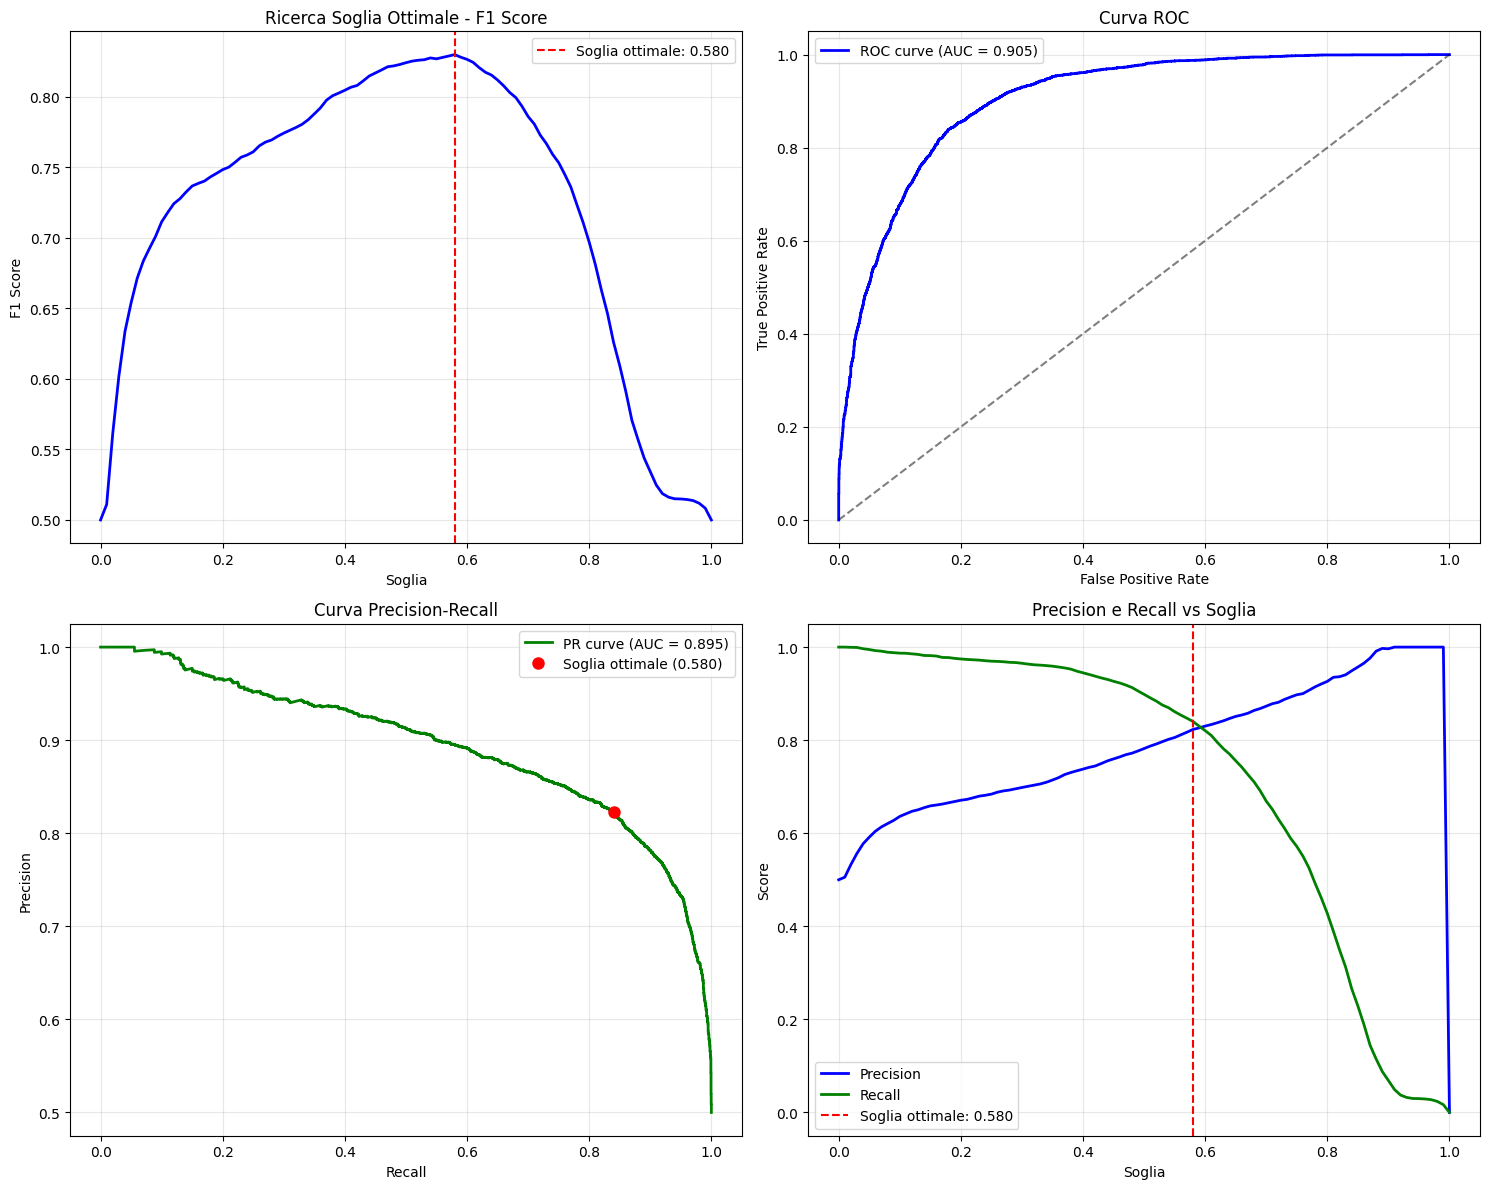


Metriche con soglia ottimale:
----------------------------------------
f1_score: 0.832
accuracy: 0.830
precision: 0.823
recall: 0.840
true_negatives: 3277
false_positives: 723
false_negatives: 639
true_positives: 3361


In [ ]:
def trova_soglia_ottimale(features_df, labels_df, 
                         test_size=0.2, 
                         random_state=42,
                         metrica='f1',
                         n_estimators=100,
                         **rf_params):
    """
    Trova la soglia ottimale per un classificatore Random Forest.
    
    Parameters:
    -----------
    features_df : pd.DataFrame
        DataFrame contenente le features
    labels_df : pd.DataFrame
        DataFrame contenente le labels (accesso tramite labels_df['0'])
    test_size : float
        Proporzione del dataset da usare come test set
    random_state : int
        Seed per la riproducibilità
    metrica : str
        Metrica da ottimizzare: 'f1', 'accuracy', 'balanced', 'precision', 'recall'
    n_estimators : int
        Numero di alberi nel Random Forest
    **rf_params : dict
        Parametri aggiuntivi per RandomForestClassifier
    
    Returns:
    --------
    dict : Dizionario contenente:
        - 'soglia_ottimale': float
        - 'metriche': dict con le metriche calcolate
        - 'model': il modello addestrato
        - 'soglie_testate': array delle soglie
        - 'scores': array degli score per ogni soglia
    """
    
    # Preparazione dei dati
    X = features_df
    y = labels_df['0']
    
    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Addestramento del modello
    print("Addestramento Random Forest...")
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                               random_state=random_state,
                               **rf_params)
    rf.fit(X_train, y_train)
    
    # Predizioni probabilistiche sul test set
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Test di diverse soglie
    soglie = np.linspace(0, 1, 101)
    scores = []
    
    print(f"Test di {len(soglie)} soglie diverse...")
    
    for soglia in soglie:
        y_pred = (y_proba >= soglia).astype(int)
        
        if metrica == 'f1':
            score = f1_score(y_test, y_pred, zero_division=0)
        elif metrica == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metrica == 'balanced':
            # Bilanciamento tra precision e recall
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        elif metrica == 'precision':
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            score = tp / (tp + fp) if (tp + fp) > 0 else 0
        elif metrica == 'recall':
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            score = tp / (tp + fn) if (tp + fn) > 0 else 0
        else:
            raise ValueError(f"Metrica '{metrica}' non supportata")
        
        scores.append(score)
    
    # Trova la soglia ottimale
    scores = np.array(scores)
    idx_ottimale = np.argmax(scores)
    soglia_ottimale = soglie[idx_ottimale]
    
    # Calcola le metriche finali con la soglia ottimale
    y_pred_ottimale = (y_proba >= soglia_ottimale).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ottimale).ravel()
    
    metriche_finali = {
        'f1_score': f1_score(y_test, y_pred_ottimale),
        'accuracy': accuracy_score(y_test, y_pred_ottimale),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp
    }
    
    print(f"\nSoglia ottimale trovata: {soglia_ottimale:.3f}")
    print(f"Score {metrica}: {scores[idx_ottimale]:.3f}")
    
    return {
        'soglia_ottimale': soglia_ottimale,
        'metriche': metriche_finali,
        'model': rf,
        'soglie_testate': soglie,
        'scores': scores,
        'y_proba': y_proba,
        'y_test': y_test
    }


def visualizza_ricerca_soglia(risultati, metrica='f1'):
    """
    Visualizza i risultati della ricerca della soglia ottimale.
    
    Parameters:
    -----------
    risultati : dict
        Output della funzione trova_soglia_ottimale
    metrica : str
        Nome della metrica ottimizzata
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafico 1: Score vs Soglia
    ax1.plot(risultati['soglie_testate'], risultati['scores'], 'b-', linewidth=2)
    ax1.axvline(x=risultati['soglia_ottimale'], color='r', linestyle='--', 
                label=f'Soglia ottimale: {risultati["soglia_ottimale"]:.3f}')
    ax1.set_xlabel('Soglia')
    ax1.set_ylabel(f'{metrica.capitalize()} Score')
    ax1.set_title(f'Ricerca Soglia Ottimale - {metrica.capitalize()} Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Grafico 2: Curva ROC
    from sklearn.metrics import  auc
    fpr, tpr, _ = roc_curve(risultati['y_test'], risultati['y_proba'])
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Curva ROC')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Grafico 3: Curva Precision-Recall
    
    precision, recall, thresholds = precision_recall_curve(risultati['y_test'], risultati['y_proba'])
    pr_auc = auc(recall, precision)
    
    ax3.plot(recall, precision, 'g-', linewidth=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    
    # Trova e marca il punto corrispondente alla soglia ottimale
    soglia_idx = np.argmin(np.abs(thresholds - risultati['soglia_ottimale']))
    ax3.plot(recall[soglia_idx], precision[soglia_idx], 'ro', markersize=8, 
             label=f'Soglia ottimale ({risultati["soglia_ottimale"]:.3f})')
    
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Curva Precision-Recall')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Grafico 4: Precision e Recall vs Soglia
    # Calcola precision e recall per ogni soglia testata
    precisions = []
    recalls = []
    
    for soglia in risultati['soglie_testate']:
        y_pred = (risultati['y_proba'] >= soglia).astype(int)
        tn, fp, fn, tp = confusion_matrix(risultati['y_test'], y_pred).ravel()
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precisions.append(prec)
        recalls.append(rec)
    
    ax4.plot(risultati['soglie_testate'], precisions, 'b-', linewidth=2, label='Precision')
    ax4.plot(risultati['soglie_testate'], recalls, 'g-', linewidth=2, label='Recall')
    ax4.axvline(x=risultati['soglia_ottimale'], color='r', linestyle='--', 
                label=f'Soglia ottimale: {risultati["soglia_ottimale"]:.3f}')
    ax4.set_xlabel('Soglia')
    ax4.set_ylabel('Score')
    ax4.set_title('Precision e Recall vs Soglia')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stampa metriche dettagliate
    print("\nMetriche con soglia ottimale:")
    print("-" * 40)
    for nome, valore in risultati['metriche'].items():
        if isinstance(valore, float):
            print(f"{nome}: {valore:.3f}")
        else:
            print(f"{nome}: {valore}")


# Esempio di utilizzo
if __name__ == "__main__":
    #risultati = trova_soglia_ottimale(features_df, labels_df, metrica='f1')
    
    # Assumendo che features_df e labels_df siano già caricati
    # risultati = trova_soglia_ottimale(features_df, labels_df, metrica='f1')
    # visualizza_ricerca_soglia(risultati)
    
    # Con parametri personalizzati per il Random Forest
    risultati = trova_soglia_ottimale(
         features_df, 
         labels_df, 
         metrica='accuracy',
         n_estimators=200,
         max_depth=10,
         min_samples_split=5,
         class_weight='balanced'
     )
    visualizza_ricerca_soglia(risultati)
   